In [4]:

from fsk_lib import fsk_modulate, build_filter_bank, correlate_bank_fft, BankDetectSettings, detect_bits_from_bank, plot_bank_results
import numpy as np


Estimated samples per bit (from centers): 440
Estimated samples per chip: 220
TX bits:      [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
RX bits (FB): [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]


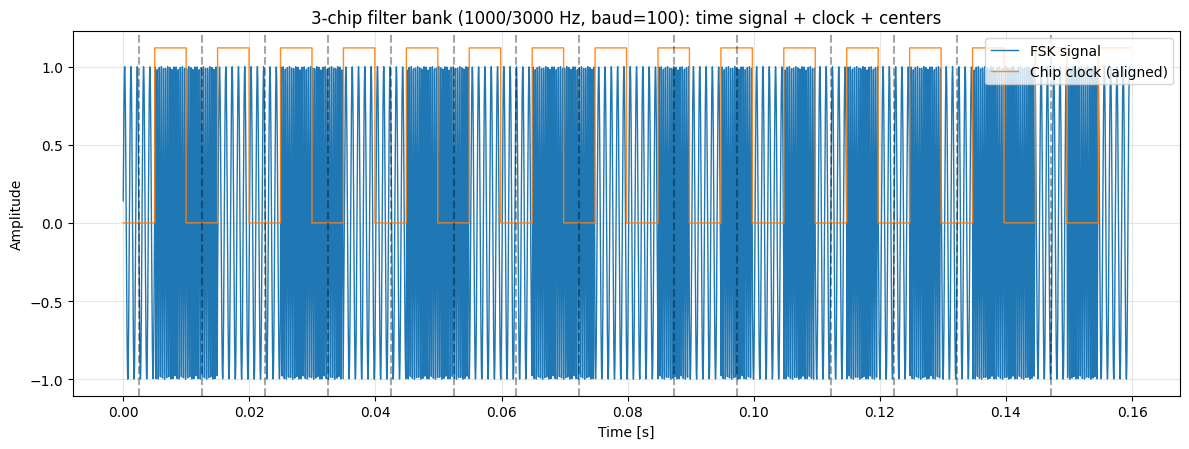

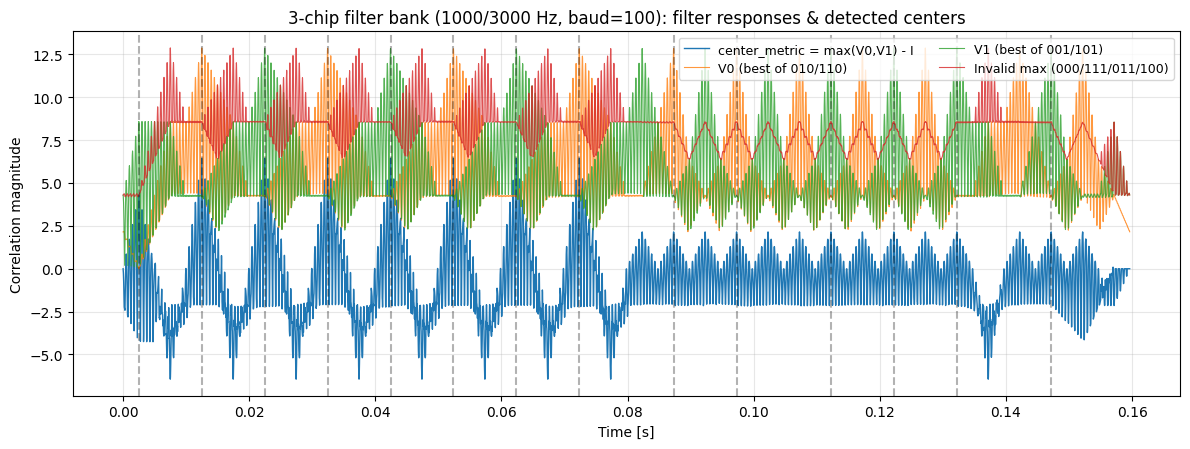

In [5]:
# Parameters
fs   = 44_100
baud = 100
f0, f1 = 1_000, 3_000

byte_vals = np.array([0x55, 0x3F ], dtype=np.uint8)
#byte_vals = np.array([0x55, 0x55, 0x55 ], dtype=np.uint8)
#byte_vals = np.array([0x55, 0x52, 0x76, 0x13, 0x98, 0xA5 ], dtype=np.uint8)
#np.random.seed(0)
#n_bytes = 16
#byte_vals = np.random.randint(0, 256, size=n_bytes, dtype=np.uint8)
tx_bits = np.unpackbits(byte_vals, bitorder='little').astype(int)


# Generate test FSK (Manchester)
sig, Lchip, chips = fsk_modulate(tx_bits, fs, baud, f0, f1, manchester=True)

# Build 3-chip filter bank and correlate (FFT)
bank   = build_filter_bank(fs, Lchip, f0, f1)
scores = correlate_bank_fft(sig, bank)

# Detect centers + bits from bank outputs
settings = BankDetectSettings(
    neighbor_alpha=0.5,
    min_peak_dist_bits=0.85,
    energy_gate_frac=0.10,
    refine_halfchip=0.5
)
result = detect_bits_from_bank(scores, fs, Lchip, settings)

# Report & plots
print("Estimated samples per bit (from centers):", result["Pbit_est"])
print("Estimated samples per chip:", result["Pchip_est"])
print("TX bits:     ", tx_bits.tolist())
print("RX bits (FB):", result["rx_bits"].tolist())

plot_bank_results(sig, fs, result,
                    title_prefix=f"3-chip filter bank ({f0}/{f1} Hz, baud={baud})")


In [ ]:
from test_clock_recovery.fsk_lib_conventional import fsk_modulate, plot_fsk_with_overlays,DemodSettings, demodulate_matched_filters, plot_demod_results
import numpy as np


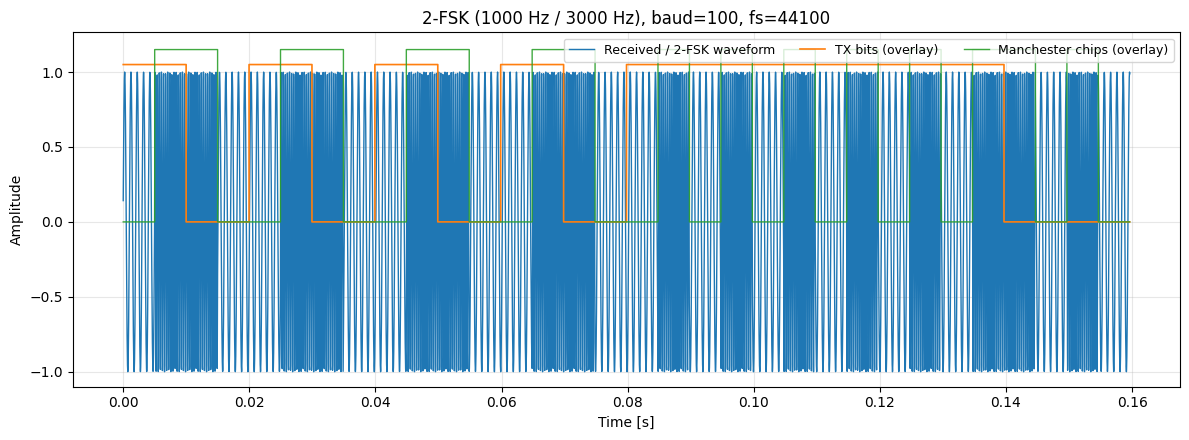

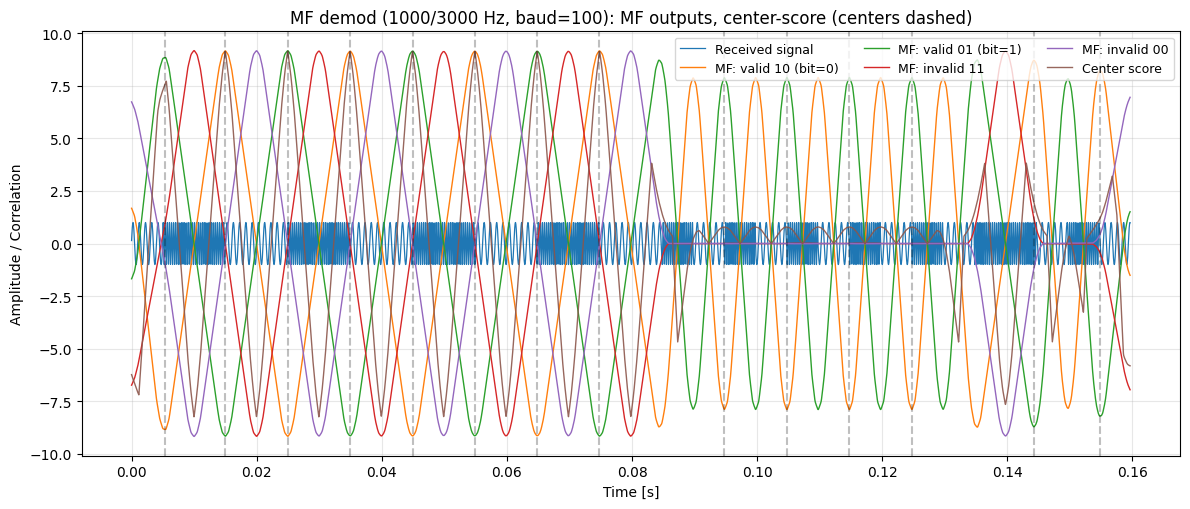

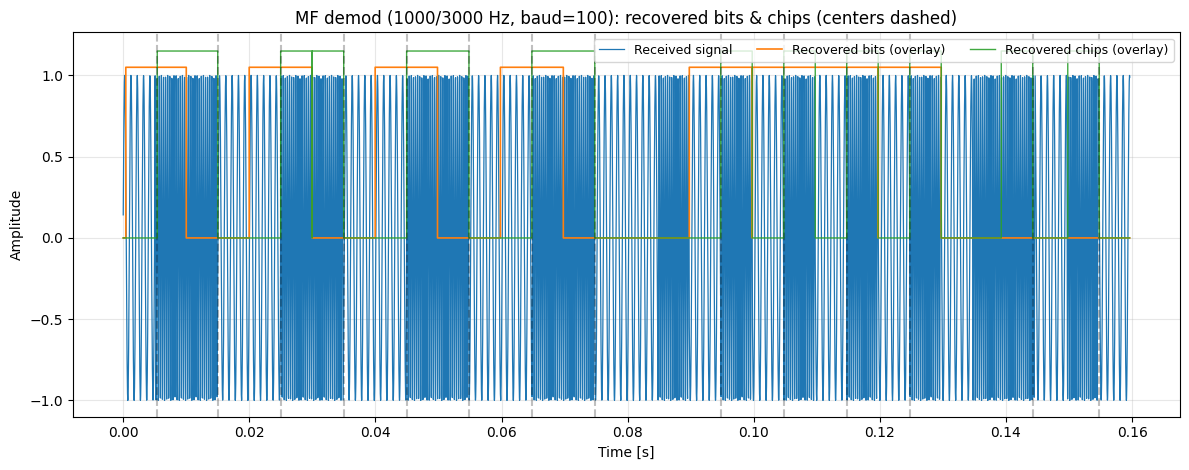

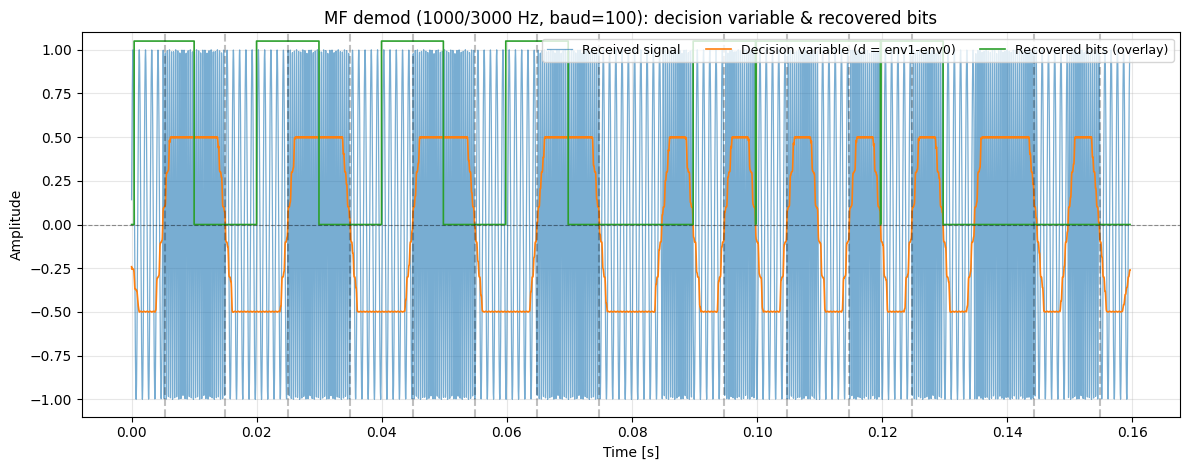

TX bits:      [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
RX bits (MF): [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0]


In [2]:
fs   = 44_100
baud = 100
f0, f1 = 1_000, 3_000

np.random.seed(0)
byte_vals = np.array([0x55, 0x3F], dtype=np.uint8)
tx_bits = np.unpackbits(byte_vals, bitorder='little').astype(int)

sig, spp_chip, chips = fsk_modulate(tx_bits, fs, baud, f0, f1, manchester=True)
plot_fsk_with_overlays(sig, fs, baud, tx_bits, chips, spp_chip,
                        title=f"2-FSK ({f0} Hz / {f1} Hz), baud={baud}, fs={fs}")

settings = DemodSettings(
    lp_len=None,
    invalid_margin=0.15,
    energy_factor=0.75,
    center_alpha=0.9,            # you asked to keep 0.9
    peak_distance_bits=0.95,
    normalize_corr=True,
    fill_search_halfchip=0.5
)
demod = demodulate_matched_filters(sig, fs, baud, f0, f1, spp_chip, settings)
plot_demod_results(sig, fs, demod, spp_chip,
                    title_prefix=f"MF demod ({f0}/{f1} Hz, baud={baud})")

print("TX bits:     ", tx_bits.tolist())
print("RX bits (MF):", demod["rx_bits"].tolist())